In [1]:
!nvidia-smi

Tue Mar 16 22:24:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:08:00.0 Off |                  N/A |
| 23%   33C    P8    11W / 250W |     15MiB / 12194MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statistics import mode
from tqdm import tqdm
import time
from keras.models import load_model
import soundtransfer
from tcn import TCN, tcn_full_summary


In [4]:
checkpoint_path = 'vggish_weights.ckpt'

In [5]:
sfreq = 16000

In [7]:
feature_mode = 'mel_spec'
mode = 'train'
features = pickle.load(open('features/{}/{}_features.pkl'.format(feature_mode, mode), 'rb'))
labels = pickle.load(open('features/{}/{}_labels.pkl'.format(feature_mode, mode), 'rb'))
features = np.concatenate(np.concatenate(features)).astype('float64')
labels = np.concatenate(np.concatenate(labels)).astype('int64')

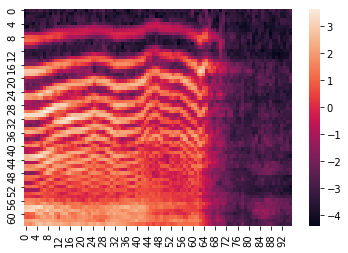

In [8]:
sns.heatmap(features[4].T)

In [9]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels)
class_weights = dict(enumerate(weights))
class_name_weights = {np.unique(labels)[key]:class_weights[key] for key in class_weights.keys()}
class_name_weights

/home/dhruv/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29], y=[ 6  6  6 ... 27 27 27] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.9702741087913649,
 1: 1.6033090823750293,
 2: 0.5239837398373983,
 3: 1.4220857618651124,
 4: 0.10539168800715806,
 5: 0.9338026243849098,
 6: 1.84590651175358,
 7: 4.023380447585395,
 8: 4.721285418106427,
 9: 2.4294807965860596,
 10: 0.35251289989680085,
 11: 3.944399538106236,
 12: 1.3647023571713943,
 13: 2.918282785134558,
 14: 5.716903765690376,
 15: 4.047215639810426,
 16: 2.017035724830233,
 17: 8.027849588719153,
 18: 1.5508967082860385,
 19: 2.065205562273277,
 20: 2.996359649122807,
 21: 4.110529482551144,
 22: 0.6580331342708534,
 23: 1.0182888657027873,
 24: 13.087547892720307,
 25: 0.46642315832593706,
 26: 1.9586295871559634,
 27: 6.402717900656045,
 28: 3.0828971119133572,
 29: 0.8820787604906392}

In [10]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(labels.reshape((-1,1))).toarray()

NUM_CLASSES = len(weights)

features = features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             vggish_params.NUM_BANDS, 1))

labels = labels.reshape((-1, NUM_CLASSES))
X_train = features
y_train = labels
del features,labels

In [11]:
feature_mode = 'mel_spec'
mode = 'test'
test_features = pickle.load(open('features/{}/{}_features.pkl'.format(feature_mode, mode), 'rb'))
test_labels = pickle.load(open('features/{}/{}_labels.pkl'.format(feature_mode, mode), 'rb'))
test_features = np.concatenate(np.concatenate(test_features)).astype('float64')
test_labels = np.concatenate(np.concatenate(test_labels)).astype('int64')

test_labels = ohe.transform(test_labels.reshape((-1,1))).toarray()

NUM_CLASSES = 30

test_features = test_features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             vggish_params.NUM_BANDS, 1))

test_labels = test_labels.reshape((-1, NUM_CLASSES))

In [12]:
X_test = test_features
y_test = test_labels
del test_labels, test_features

In [13]:
print('X train shape {}'.format(X_train.shape))
print('X test  shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test  shape {}'.format(y_test.shape))

X train shape (204951, 96, 64, 1)
X test  shape (26154, 96, 64, 1)
y train shape (204951, 30)
y test  shape (26154, 30)


In [23]:
# Define VGGish, load the checkpoint, and run the batch through the model to produce embeddings
model_name = 'vggish_tcn'

learning_rate=vggish_params.LEARNING_RATE
epsilon1=vggish_params.ADAM_EPSILON

model=vggish_keras.get_vggish_keras()
model.load_weights(checkpoint_path)

last=model.output
o = Reshape((128,1))(last)
o = TCN(return_sequences=False)(o)
main_out=Dense(NUM_CLASSES, activation='sigmoid', name='main_out')(o)
model=Model(model.input, main_out)

ADAM=Adam(lr=learning_rate, epsilon=epsilon1)
model.compile(optimizer=ADAM, loss='binary_crossentropy', metrics=['categorical_accuracy'])

# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))
checkpoint=ModelCheckpoint('checkpoints/model_{}.h5'.format(model_name), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping=EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001) 

In [24]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)      

In [25]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

Epoch 1/100
3203/3203 [==============================] - ETA: 0s - loss: 0.0933 - categorical_accuracy: 0.4566
Epoch 00001: val_categorical_accuracy improved from -inf to 0.66319, saving model to checkpoints/model_vggish_tcn.h5
3203/3203 [==============================] - 147s 46ms/step - loss: 0.0933 - categorical_accuracy: 0.4566 - val_loss: 0.0647 - val_categorical_accuracy: 0.6632
Epoch 2/100
3203/3203 [==============================] - ETA: 0s - loss: 0.0441 - categorical_accuracy: 0.6464
Epoch 00002: val_categorical_accuracy improved from 0.66319 to 0.67802, saving model to checkpoints/model_vggish_tcn.h5
3203/3203 [==============================] - 152s 47ms/step - loss: 0.0441 - categorical_accuracy: 0.6464 - val_loss: 0.0688 - val_categorical_accuracy: 0.6780
Epoch 3/100
3203/3203 [==============================] - ETA: 0s - loss: 0.0291 - categorical_accuracy: 0.7129
Epoch 00003: val_categorical_accuracy improved from 0.67802 to 0.70054, saving model to checkpoints/model_vggi

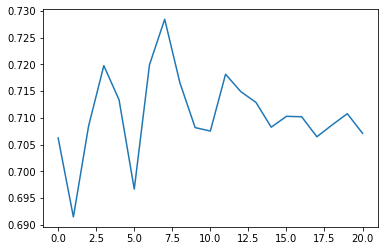

In [38]:
plt.plot(history.history['val_categorical_accuracy'])

### Contextual Results

In [17]:
model.load_weights('checkpoints/model_{}.h5'.format(sfreq))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [18]:
labels_test = ohe.inverse_transform(y_test).flatten()

In [19]:
pred = model.predict(X_test)

In [20]:
np.unique(labels_test)

array(['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'], dtype='<U32')

In [21]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(labels_test)}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [22]:
for context in contexts.keys():
#     context = list(contexts.keys())[0]
    valid_idx = [i for i, label in enumerate(labels_test) if label in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = np.argmax(valid_pred * context_encoding[context], axis=1)
    valid_pred = [ohe.categories_[0][pr] for pr in valid_pred]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{}, {}, {}, {}'.format(sfreq, context, acc, f1))
    # fig, ax = plt.subplots(figsize=(13,10))
    # sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    # ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    # ax.set_xlabel('Predicted Label')
    # ax.set_ylabel('True Label')

250, monolithic, 0.24025080287505735, 0.21753807234584813
250, bathroom, 0.4432389937106918, 0.3767953629978072
250, kitchen, 0.3242099322799097, 0.23509611885221973
250, bedroom, 0.27311387620097655, 0.24571837773417937
250, office, 0.3991017500387177, 0.438140046030926
250, entrance, 0.261678104936905, 0.3186410410470032
250, workshop, 0.2824427480916031, 0.2560457100237921
250, outdoor, 0.3335302806499261, 0.2292495039714536


### File-Level Metrics 

In [27]:
feature_mode = 'mel_spec'
mode = 'test'
test_features = pickle.load(open('features/{}/{}_features.pkl'.format(feature_mode, mode), 'rb'))
test_labels = pickle.load(open('features/{}/{}_labels.pkl'.format(feature_mode, mode), 'rb'))

test_features_flat = []
for cls in test_features:
    for file in cls:
        if len(file) != 0:
            test_features_flat.append(file)

test_labels_ohe = []
for cls in test_labels:
    for file in cls:
        if len(file) != 0:
            file_labels = ohe.transform(np.array(file).reshape((-1,1))).toarray()
            test_labels_ohe.append(file_labels)

NUM_CLASSES = 30

X_test = [file.reshape((-1, vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1)) for file in test_features_flat] 
y_test = [file.reshape((-1, NUM_CLASSES)) for file in test_labels_ohe]

In [28]:
model.load_weights('checkpoints/model_{}.h5'.format(model_name))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [29]:
labels_test = np.array([ohe.inverse_transform(file).flatten() for file in y_test])

In [30]:
pred = np.array([model.predict(file) for file in X_test])

In [31]:
label_int = soundtransfer.label
label_inv = soundtransfer.label_inv

encoding = {label: ohe.transform([[label]]).toarray() for label in ohe.categories_[0]}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[label_int[activity]]    

In [32]:
for context in contexts.keys():
    valid_idx = [i for i, label in enumerate(labels_test) if label[0] in [label_int[x] for x in contexts[context]]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = [file * context_encoding[context] for file in valid_pred]

    # Transform to per file level labels
    valid_pred = [np.argmax(np.sum(file, axis=0)) for file in valid_pred]
    valid_labels = [file[0] for file in valid_labels]

    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    # label_names = np.unique(valid_labels)
    print('{},{},{}'.format(context, acc, f1))

monolithic,0.7900477164280846,0.786789101413722
bathroom,0.9359430604982206,0.935280808042485
kitchen,0.8272727272727273,0.820865863201876
bedroom,0.9203187250996016,0.9216175460911974
office,0.9578313253012049,0.9580662851282215
entrance,0.8605577689243028,0.8624109616228934
workshop,0.8741007194244604,0.8713101697833592
outdoor,0.9127272727272727,0.9142474891026211


In [84]:
valid_idx

[]